In [ ]:
# Initial imports
from astropy.stats import gaussian_fwhm_to_sigma as g2s
import glob
import numpy as np
import time
from pypeutils.resampling.resample import *
import matplotlib.pyplot as plt
import tempfile
import warnings

# pyredux needs to be installed
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ImportError)
    from redux.sofia.fifils_reduction import FIFILSReduction
    
# pyfifi needs to be installed
from fifi_ls.resample import combine_files, get_grid_info

files = glob.glob('/Users/dperera/test_data/pacman/reduce/*RED_WSH*.fits')
outfile = 'pacman.fits'
framei = 35
# files = glob.glob('/Users/dperera/test_data/fifi-ls/large_wsh/*WSH*.fits')
# outfile = 'large.fits'
# framei = 21
red = FIFILSReduction()
red.load(files)
red.load_parameters()
hduls = red.input
param = red.get_parameter_set()
save = param.get_value('save')
error_weighting = param.get_value('error_weighting')
xy_oversample = param.get_value('xy_oversample')
w_oversample = param.get_value('w_oversample')
xy_order = param.get_value('xy_order')
w_order = param.get_value('w_order')
xy_window = param.get_value('xy_window')
w_window = param.get_value('w_window')
xy_smoothing = param.get_value('xy_smoothing')
w_smoothing = param.get_value('w_smoothing')
fitthresh = param.get_value('fitthresh')
posthresh = param.get_value('posthresh')
negthresh = param.get_value('negthresh')
xythresh = param.get_value('xy_edge_threshold')
wthresh = param.get_value('w_edge_threshold')

#######
xy_order = 2
#######

order = xy_order, xy_order, w_order
edge_threshold = xythresh, xythresh, wthresh
window = xy_window, xy_window, w_window
oversample = xy_oversample, w_oversample
smoothing = xy_smoothing, xy_smoothing, w_smoothing

robust = None
neg_threshold = None
fit_threshold = 0
edge_mode = 'edges'
fix_order = True
write = False

combined = combine_files(hduls)
grid_info = get_grid_info(combined, oversample=oversample)
grid = grid_info['grid']

fit_wdw = (window[0] * grid_info['xy_fwhm'],
           window[1] * grid_info['xy_fwhm'],
           window[2] * grid_info['wave_fwhm'])

flxvals = np.hstack([f.ravel() for f in combined['FLUX']])
errvals = np.hstack([e.ravel() for e in combined['ERROR']])

settings = {'smoothing': smoothing, 'fit_threshold': fit_threshold,
            'error_weighting': error_weighting,
            'edge_algorithm': 'com_distance',
            'edge_threshold': edge_threshold,
            'get_error': True, 'get_counts': True,
            'jobs': -2}

resampler = Resample(grid_info['coordinates'].copy(), flxvals, error=errvals,
                     fix_order=fix_order, window=fit_wdw, order=order, robust=None,
                     negthresh=None, mode=edge_mode)
self = resampler
fit_threshold = 0
edge_algorithm = 'com_distance'
relative_smooth = False
error_weighting = False
get_error = True
jobs = -1
client = None
cval = np.nan
fwhm = grid_info['xy_fwhm'], grid_info['xy_fwhm'], grid_info['wave_fwhm']
smoothing = g2s * fwhm[0], g2s * fwhm[1], 0.25 * fwhm[2]  # fwhm or alpha
adaptive_threshold = 1, 1, 0
get_covar = False
mise = True
cross_validate = False
is_covar = False
fast_error = True

settings = self.reduction_settings(
    smoothing, fit_threshold, cval, edge_threshold, edge_algorithm,
    relative_smooth, error_weighting,
    adaptive_threshold, is_covar, fast_error, jobs, client)


grid = grid_info['grid']
args = grid
from astropy.stats import gaussian_fwhm_to_sigma
import bottleneck as bn
import numpy as np
from scipy.special import gamma
import warnings
from pypeutils.resampling.resample import scale_coordinates
from pypeutils.resampling.resample import ResampleGrid
from pypeutils.resampling.resample_utils import gaussian_matrix

def imshow(val): 
        plt.imshow(val[0].reshape(visitor_grid.shape)[framei]) 

        
        
        
        
        
result = resampler(*grid if not cross_validate else grid_info['coordinates'].copy(),
                   smoothing=smoothing,
                   adaptive_threshold=adaptive_threshold,
                   error_weighting=True, jobs=-1)

if cross_validate:
    args = (grid_info['coordinates'].copy(),)
else:
    args = grid

self._check_call_arguments(*args, smoothing=smoothing,
                   edge_algorithm=edge_algorithm,
                   edge_threshold=edge_threshold)

visitor_grid = ResampleGrid(
    *args, tree_shape=self.local_tree.tree_shape,
    build_tree=True, scale_factor=self._radius,
    scale_offset=self._scale_offsets, dtype=np.float64)

get_error=True
get_counts=True
get_weights=True
get_rchi2=True
data = self.data
error = self.error
mask = self.mask

adaptive = settings['adaptive_threshold']
do_adaptive = adaptive is not None
if do_adaptive:
    adaptive = np.atleast_1d(adaptive).astype(float)
    if adaptive.size == 0 or np.allclose(adaptive, 0):
        do_adaptive = False

if not do_adaptive:
    settings['adaptive_threshold'] = None
    settings['adaptive_alpha'] = np.empty((0, 0, 0))

if settings['order_symmetry']:
    o = settings['order'][0]
else:
    o = settings['order']

visitor_tree = visitor_grid.tree
visitor_tree.set_order(o, order_required=settings['order_required'],
                       method=settings['order_method'])
visitor_tree.precalculate_powers()

required = settings['order_required']
local_tree = self.local_tree
block = 274  # 183 in data domain
local_powers = local_tree.powers
visitor_powers = visitor_tree.powers
local_coordinates = local_tree.coordinates
power_order_idx = local_tree.power_order_idx
from pypeutils.resampling.resample_utils import check_edges 
get_distance_weights = False
principle_idx = self.local_tree.principle_indices
get_cov = True

visitor_members, visitor_coordinates = visitor_tree.block_members(
    block, get_locations=True)

local_members = local_tree.query_radius(
    visitor_coordinates, 1.0, return_distance=False)


###### TREE INTERSECTION

n_sets = data.shape[0]
features = local_coordinates.shape[0]
n_visitors = visitor_members.size
fit_out = np.empty((n_sets, n_visitors))

if get_error:
    error_out = np.empty((n_sets, n_visitors))
else:
    error_out = fit_out

if get_counts:
    counts_out = np.empty((n_sets, n_visitors), dtype=np.int64)
else:
    counts_out = fit_out

if get_weights:
    weights_out = np.empty((n_sets, n_visitors), dtype=np.float64)
else:
    weights_out = fit_out

if get_distance_weights:
    distance_weights_out = np.empty((n_sets, n_visitors), dtype=np.float64)
else:
    distance_weights_out = fit_out

if get_rchi2:
    rchi2_out = np.empty((n_sets, n_visitors), dtype=np.float64)
else:
    rchi2_out = fit_out

if get_cov:
    cov_out = np.zeros((n_sets, n_visitors, features, features),
                       dtype=np.float64)
else:
    cov_out = np.empty((1, 0, 0, 0))

error_weighting = settings['error_weighting']
distance_weighting = settings['distance_weighting']
alpha = settings['alpha']
adaptive_alpha = settings['adaptive_alpha']
order = settings['order']
order_required = settings['order_required']
order_varies = settings['order_varies']
minimum_points = settings['order_minpoints']
order_algorithm_idx = settings['order_algorithm_idx']
fit_threshold = settings['fit_threshold']
is_covar = settings['is_covar']
order_is_zero = settings['order_is_zero']
check_order0 = settings['check_order0']
cval = settings['cval']
edge_threshold = settings['edge_threshold']
edge_algorithm_idx = settings['edge_algorithm_idx']
have_error = settings['have_error']
fast_error = settings['fast_error']

visitor_id = 0

visitor = visitor_members[visitor_id]
local_submembers = local_members[visitor_id]

############# SOLVE VISITOR


nsets = data.shape[0]
local_subcoord = local_coordinates[:, local_submembers]
visitor_subcoord = visitor_coordinates[:, visitor_id]

check_edges(edge_algorithm_idx, local_subcoord,
            visitor_subcoord, edge_threshold)


if adaptive_alpha.size == 0:
    adaptive_smoothing = False
    dweights = calculate_distance_weights(
        local_subcoord, visitor_subcoord, alpha)
    adaptive_dweights = np.empty((0, 0))
else:
    adaptive_smoothing = True
    dweights = alpha
    adaptive_dweights = calculate_adaptive_distance_weights(
        local_subcoord, visitor_subcoord, local_submembers, adaptive_alpha)

from pypeutils.resampling.resample_utils import calculate_distance_weights
# Calculate distance weights if needed (not needed: alpha = [0])
if adaptive_alpha.size == 0:
    adaptive_smoothing = False
    dweights = calculate_distance_weights(
        local_subcoord, visitor_subcoord, alpha)
    adaptive_dweights = np.empty((0, 0))
else:
    adaptive_smoothing = True
    dweights = alpha
    adaptive_dweights = calculate_adaptive_distance_weights(
        local_subcoord, visitor_subcoord, local_submembers, adaptive_alpha)

# Arrays for all datasets within window region
subdata = data[:, local_submembers]
submask = mask[:, local_submembers]
sublocal_powers = local_powers[:, local_submembers]
subvisitor_powers = visitor_powers[:, visitor]
variable_error = error.shape[1] > 1
if variable_error:
    suberror = error[:, local_submembers]
else:
    suberror = error  # This is expanded in prune_equation_arrays

# Determine whether to check fits and what to do with failures
check_fit = fit_threshold != 0
if check_fit:
    if fit_threshold < 0:
        replace_rejects = False
        fit_threshold *= -1
    else:
        replace_rejects = True
else:
    replace_rejects = False

# Switches determining what needs to be calculated
rchi2_required = get_rchi2 or check_fit
error_required = get_error or get_cov or (
        rchi2_required and not have_error)
weightsum_required = (order_is_zero or get_error or
                      rchi2_required or is_covar or get_weights)
residual_required = rchi2_required or (error_required and not have_error)
weight_is_variance = error_weighting and not distance_weighting


dataset = 0
    

from pypeutils.resampling.resample_utils import mask_count
set_mask = submask[dataset]
counts = mask_count(set_mask)
    
from pypeutils.resampling.resample_utils import check_orders
set_order = check_orders(
    order_algorithm_idx, local_subcoord, visitor_subcoord,
    set_mask, order,  minimum_points, required)
    
set_data = subdata[dataset]
set_error = suberror[dataset]

# Check if this is a zero order polynomial (mean)
do_weightsum = weightsum_required
do_order_zero = order_is_zero
if check_order0:
    for o in set_order:
        if o != 0:
            break
    else:
        do_order_zero = True
        do_weightsum = True

# Select the correct order set in the case that orders vary
# This only works for symmetrical orders
if order_varies:
    oidx = order_idx[set_order[0]: set_order[0] + 2]
    set_visitor_power = subvisitor_powers[oidx[0]: oidx[1]]
    set_local_power = sublocal_powers[oidx[0]: oidx[1]]
else:
    set_visitor_power = subvisitor_powers
    set_local_power = sublocal_powers
    

dw = dweights

import math
from pypeutils.resampling.resample_utils import prune_equation_arrays
set_data, set_local_power, set_error, set_dweights = \
    prune_equation_arrays(counts, set_mask, set_data,
                          set_local_power, set_error, dw)
    
from pypeutils.resampling.resample_utils import calculate_set_weights
set_weight = calculate_set_weights(
    set_error, set_dweights, error_weighting)
    
from pypeutils.resampling.resample_utils import sum_weights
weightsum = sum_weights(set_weight)

fitted, variance, rchi2, cov = solve_polynomial_fit(
    set_data, set_error, set_weight, set_local_power,
    set_visitor_power, weightsum, principle_idx,
    residual_required, error_required, rchi2_required,
    get_cov, have_error, weight_is_variance, fast_error)




########### SOLVE POLYNOMIAL FIT

principle = principle_idx.copy()
phi_samples = set_local_power.copy()
phi_point = set_visitor_power.copy()
calculate_cov = get_cov

from pypeutils.resampling.resample_utils import(
solve_amat_beta, solve_coefficients, fitted_mean, fit_residual,
fitted_variance, principle_covariance, njit, solve_rchi2_from_error,
solve_rchi2_from_variance
)

amat, beta = solve_amat_beta(phi_samples, set_data, set_weight)
rank, coefficients = solve_coefficients(amat, beta)
fitted = fitted_mean(phi_point, coefficients)
residuals = fit_residual(set_data, phi_samples, coefficients)
    
measure = set_error
    
variance, covariance = fitted_variance(
    measure, set_weight, amat, phi_samples, phi_point,
    weight_is_variance, rank, fast_error)

kshape = principle_covariance(covariance, principle)

    

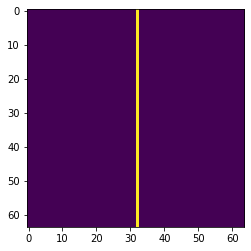

In [1]:
# Initial imports
from astropy.stats import gaussian_fwhm_to_sigma
import glob
import numpy as np
import time
from pypeutils.resampling.resample import *
import matplotlib.pyplot as plt
import tempfile
import warnings
from pypeutils.resampling.resample_utils import calculate_distance_weights_matrix
# %matplotlib inline

image = np.zeros((256, 256))
image[96:160, 96:160] = 1
error = 1e-3

noise = np.random.random(image.shape) * 1e-2
image += noise

xout, yout = np.linspace(80, 112, 32), np.linspace(80, 112, 32)
y, x = np.mgrid[:256, :256]
coordinates = np.stack([x.ravel(), y.ravel()])

cout = np.stack([xout, np.full(32, 128)])

points = np.stack([
    [96, 128, 160,  96, 128, 160,  96, 128, 160],
    [96,  96,  96, 128, 128, 128, 160, 160, 160]
]).astype(float)

# tl, tc, tr, ml, mc, mr, bl, bc, br

xout, yout = np.arange(256), np.arange(256)

resampler = Resample(coordinates, image.ravel(), order=2, window=9,
                     error=error, mode='extrapolate')

sigma = gaussian_fwhm_to_sigma * 3


bad_point = np.array([[7.0],[108]])


i0, w0, s0, cov = resampler(xout, yout, jobs=-1,
                        smoothing=sigma,
                        get_distance_weights=True,
                        get_cov=True,
                        get_rchi2=True)

ia, wa = resampler(xout, yout, jobs=-1, smoothing=sigma,
                        adaptive_threshold=1.0,
                        get_distance_weights=True)


from pypeutils.resampling.resample_utils import rescale_gradient_matrices
from pypeutils.resampling.resample_utils import gaussian_matrix
yg, xg = np.mgrid[:64, :64]
xc = np.stack([xg.ravel() * 1.0, yg.ravel()]) / 16
center = np.array([32.0, 32.0]) / 16

# i = 0  # tl
# i = 1  # tc
# i = 2  # tr
# i = 3  # ml
# i = 4  # mc
# i = 5  # mr
# i = 6  # bl
# i = 7  # bc
# i = 8  # br

mats = create_gaussian_matrices(cov, fixed, s0, base)
t = mats[i]
wg = calculate_distance_weights_matrix(xc, center, t).reshape(64, 64)
plt.imshow(wg)



# OR
g = cov[i].copy()
fixed = np.array([False, False])
scale = s0[i]
base = np.ones(2)

t = gaussian_matrix(g, fixed, scale, base)


yg, xg = np.mgrid[:64, :64]
xc = np.stack([xg.ravel() * 1.0, yg.ravel()]) / 16
center = np.array([32.0, 32.0]) / 16
wg = calculate_distance_weights_matrix(xc, center, t).reshape(64, 64)
plt.imshow(wg)


######### OLDER

for g in cov:
    u, s, v = np.linalg.svd(g)
    dr = np.sqrt(np.prod(s)) ** (1 / s.size)
    print((i, dr))

# Plotting
g = cov[i].copy()
t = g / np.abs(np.diag(g)).max()

yg, xg = np.mgrid[:64, :64]
xc = np.stack([xg.ravel() * 1.0, yg.ravel()]) / 16
center = np.array([32.0, 32.0]) / 16
wg = calculate_distance_weights_matrix(xc, center, t).reshape(64, 64)
plt.imshow(wg)

